Add image path from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
shared_folder_path = '/content/drive/My Drive/Data'

In [3]:
import os

for filename in os.listdir(shared_folder_path):
    print(filename)

features_30_sec.csv
features_3_sec.csv
images_original
genres_original
quantized_resnet18.pth
original_model.h5
pruned_model.h5
pruned_model.h5.gz
original_resnet18.pth


# Resnet

In [4]:
import torch
import torchvision
# import torchaudio
import random
import numpy as np
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

<ipython-input-4-a3a4c313d453>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
img_path = '/content/drive/My Drive/Data/images_original'

In [6]:
batch_size = 8
image_size = 224

In [7]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [8]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [9]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [10]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

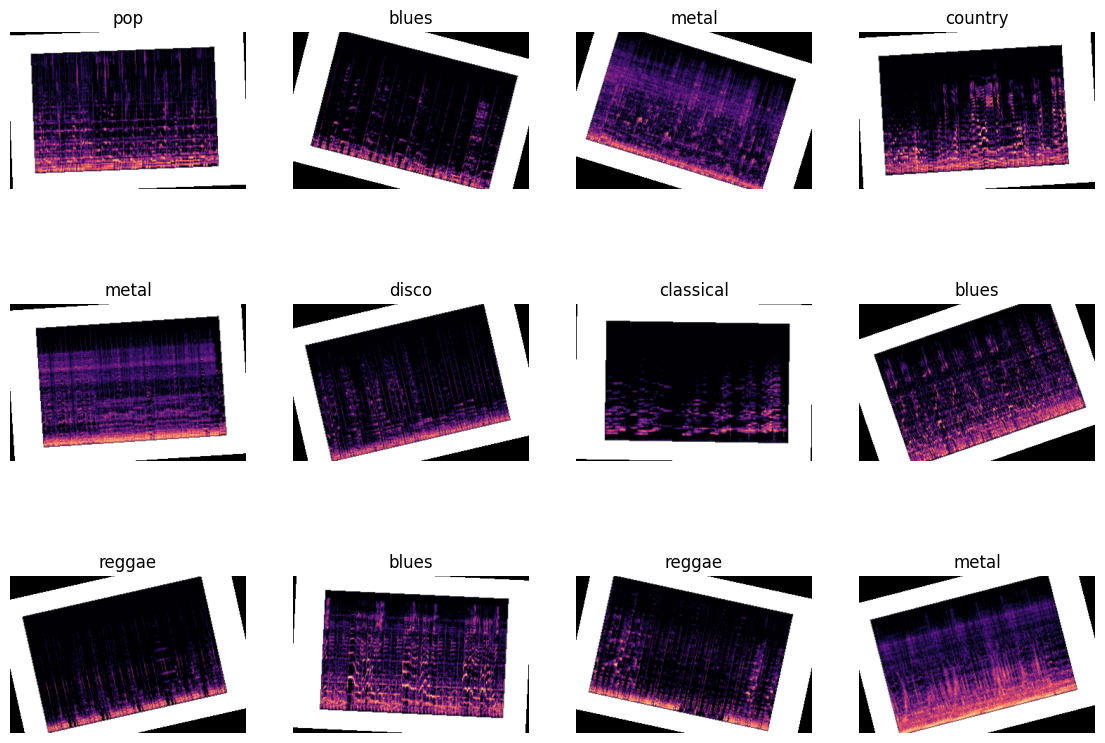

In [11]:
class_plot(train_data)

In [12]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [13]:
print('The validation size is ', val_size)
print('The train size is ', train_size)

The validation size is  99
The train size is  900


In [14]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [16]:
print(len(train_dl))

113


images.shape: torch.Size([8, 3, 224, 336])


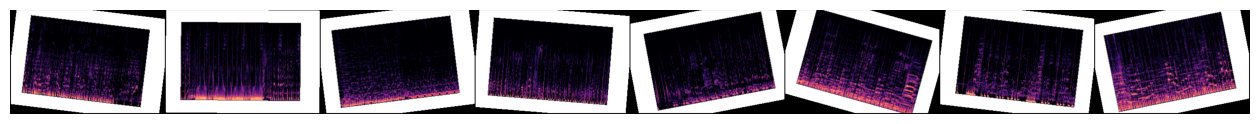

In [17]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [18]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [19]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [20]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [21]:
Net()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [22]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def train_model(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_loss = 0.0
        train_corrects = 0
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history






def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(Net(), device)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Resnet18

In [26]:
import time

# Record the start time
start_time = time.time()

epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
model.freeze()
history1a = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
model.unfreeze()



# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time
print(f"Total time taken for training: {total_time:.2f} seconds")

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.9393, val_score: 0.2857


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.5193, val_score: 0.5238


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6707, val_score: 0.4583


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.4379, val_score: 0.5000


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2587, val_score: 0.5446
Total time taken for training: 2036.36 seconds


In [27]:
# Save the record
import pickle
save_directory = "/content/drive/My Drive/Data/saved_data"
os.makedirs(save_directory, exist_ok=True)
# Save the history1a and total_time to a file
with open(os.path.join(save_directory, "history1a.pkl"), "wb") as f:
    pickle.dump({"history1a": history1a, "total_time1a": total_time}, f)


In [28]:
epochs = 5
max_lr = 0.000001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

In [33]:
start_time = time.time()
# Resnet18
history1b = train_model(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time1b = end_time - start_time
print(f"Total time taken for training: {total_time1b:.2f} seconds")

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.2805, val_score: 0.5446


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.2618, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.2514, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1747, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2353, val_score: 0.5625
Total time taken for training: 2069.56 seconds


In [34]:
# Save the record
import pickle
save_directory = "/content/drive/My Drive/Data/saved_data"
os.makedirs(save_directory, exist_ok=True)
# Save the history1a and total_time to a file
with open(os.path.join(save_directory, "history1b.pkl"), "wb") as f:
    pickle.dump({"history1b": history1b, "total_time1b": total_time1b}, f)


In [ ]:
# max_val_score = 0
# for i in range(len(history)):
#     if max_val_score < history[i]['val_score']:
#         max_val_score = history[i]['val_score']

# print('max val_score:', max_val_score)

max val_score: 0.6101189851760864


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Data/original_resnet18.pth')

experiment2

In [31]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_model2(epochs, max_lr, model, train_loader, val_loader, 
                weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_loss = 0.0
        lrs = []
        
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_loss += loss.item() * batch[0].size(0) # Update train loss
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Calculate average train loss for the epoch
        train_dataset_len = len(train_loader)
        avg_train_loss = train_loss / train_dataset_len
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = avg_train_loss # Add train loss to the result
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [35]:
import time

# Record the start time
start_time = time.time()

epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
model.freeze()
history2a = train_model2(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
model.unfreeze()



# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time2a = end_time - start_time
print(f"Total time taken for training: {total_time2a:.2f} seconds")

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.7511, val_score: 0.4286


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.4721, val_score: 0.4494


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.5107, val_score: 0.4911


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2520, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1610, val_score: 0.5923
Total time taken for training: 1989.96 seconds


In [36]:
# Save the record
import pickle
save_directory = "/content/drive/My Drive/Data/saved_data"
os.makedirs(save_directory, exist_ok=True)
# Save the history1a and total_time to a file
with open(os.path.join(save_directory, "history2a.pkl"), "wb") as f:
    pickle.dump({"history2a": history2a, "total_time2a": total_time2a}, f)



In [37]:
import time

# Record the start time
start_time = time.time()

epochs = 5
max_lr = 0.000001
grad_clip = 0.3
weight_decay = 5e-3
opt_func = torch.optim.Adam

model.freeze()
history2b = train_model2(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
model.unfreeze()



# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time2b = end_time - start_time
print(f"Total time taken for training: {total_time2b:.2f} seconds")

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.1490, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.1332, val_score: 0.6071


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.1114, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.1385, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.1595, val_score: 0.5804
Total time taken for training: 1982.84 seconds


In [38]:
# Save the record
import pickle
save_directory = "/content/drive/My Drive/Data/saved_data"
os.makedirs(save_directory, exist_ok=True)
# Save the history1a and total_time to a file
with open(os.path.join(save_directory, "history2b.pkl"), "wb") as f:
    pickle.dump({"history2b": history2b, "total_time2b": total_time2b}, f)

Using smaller models (e.g., MobileNetV2):

In [39]:
import torchvision.models as models

class MobileNetV2Model(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.mobilenet_v2(pretrained=True)
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, 10)

    def forward(self, xb):
        return self.network(xb)

model2 = to_device(MobileNetV2Model(), device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.2MB/s]


In [40]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
# Record the start time
start_time = time.time()
history3 = train_model(epochs, max_lr, model2, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time3 = end_time - start_time
print(f"Total time taken for training: {total_time3:.2f} seconds")

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.8041, val_score: 0.3393


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.7862, val_score: 0.4494


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.5043, val_score: 0.4464


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2786, val_score: 0.6220


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2661, val_score: 0.5446
Total time taken for training: 1114.06 seconds


In [41]:
# Save the record
import pickle
save_directory = "/content/drive/My Drive/Data/saved_data"
os.makedirs(save_directory, exist_ok=True)
# Save the history1a and total_time to a file
with open(os.path.join(save_directory, "history3.pkl"), "wb") as f:
    pickle.dump({"history3": history3, "total_time3": total_time3}, f)

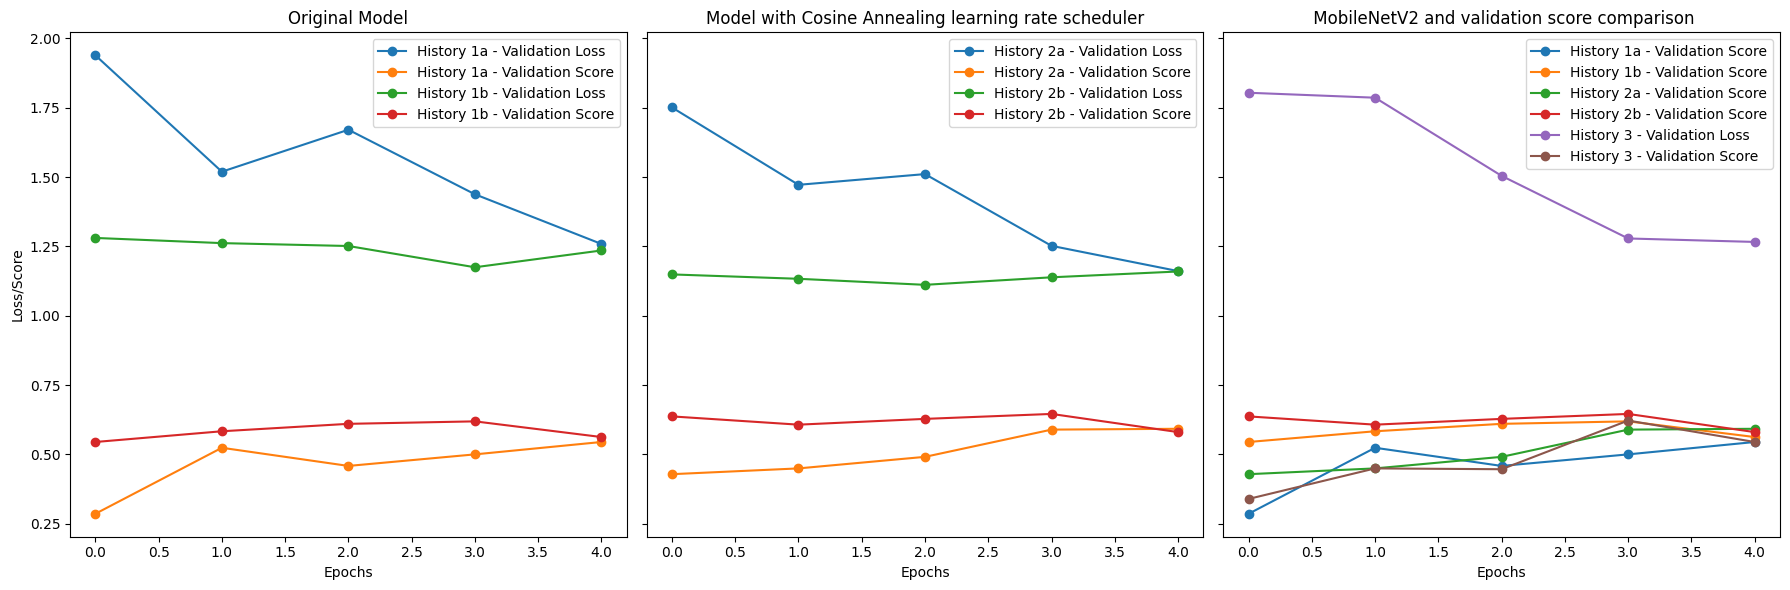

In [48]:
import matplotlib.pyplot as plt

def plot_histories(history1a, history1b, history2a, history2b, history3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Plot history1a and history1b
    axes[0].plot([x['val_loss'] for x in history1a], '-o', label='History 1a - Validation Loss')
    axes[0].plot([x['val_score'] for x in history1a], '-o', label='History 1a - Validation Score')
    axes[0].plot([x['val_loss'] for x in history1b], '-o', label='History 1b - Validation Loss')
    axes[0].plot([x['val_score'] for x in history1b], '-o', label='History 1b - Validation Score')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss/Score')
    axes[0].set_title('Original Model')
    axes[0].legend()

    # Plot history2a and history2b
    axes[1].plot([x['val_loss'] for x in history2a], '-o', label='History 2a - Validation Loss')
    axes[1].plot([x['val_score'] for x in history2a], '-o', label='History 2a - Validation Score')
    axes[1].plot([x['val_loss'] for x in history2b], '-o', label='History 2b - Validation Loss')
    axes[1].plot([x['val_score'] for x in history2b], '-o', label='History 2b - Validation Score')
    axes[1].set_xlabel('Epochs')
    axes[1].set_title('Model with Cosine Annealing learning rate scheduler')
    axes[1].legend()

    # Plot history3
    axes[2].plot([x['val_score'] for x in history1a], '-o', label='History 1a - Validation Score')
    axes[2].plot([x['val_score'] for x in history1b], '-o', label='History 1b - Validation Score')
    axes[2].plot([x['val_score'] for x in history2a], '-o', label='History 2a - Validation Score')
    axes[2].plot([x['val_score'] for x in history2b], '-o', label='History 2b - Validation Score')
    axes[2].plot([x['val_loss'] for x in history3], '-o', label='History 3 - Validation Loss')
    axes[2].plot([x['val_score'] for x in history3], '-o', label='History 3 - Validation Score')
    axes[2].set_xlabel('Epochs')
    axes[2].set_title(' MobileNetV2 and validation score comparison')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Assuming the histories are loaded as history1a, history1b, history2a, history2b, and history3
plot_histories(history1a, history1b, history2a, history2b, history3)
